In [1]:
from multiprocessing import Pool
from tqdm.notebook import tqdm

import numpy as np
from scipy.signal import resample

from timescales.autoreg import compute_ar_spectrum
from timescales.sim import sim_probs_combined, sim_spikes_prob, sim_spikes_synaptic
from timescales.fit import PSD
from timescales.fit.utils import convert_knee_val
from timescales.plts import plot_connected_scatter, set_default_rc

from neurodsp.spectral import compute_spectrum
from neurodsp.sim import sim_synaptic_kernel

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
set_default_rc()

In [3]:
def osc_parallel_fit(seed):
    """Fit oscillatory simulations for spikes in parallel."""
    
    # Settings
    np.random.seed(seed)
    
    n_seconds = 100
    fs = 10000
    f_range = (1, 40)

    # Simulate (a)periodic spiking probabilities
    ap_freq = 10
    pe_freq = 20
    ap_sim_kwargs = dict(mu=250, refract=0)
    
    probs_ap, probs_pe = sim_probs_combined(
        n_seconds, 5000, ap_freq, pe_freq, ap_sim_kwargs,
        heights=(.8, .2)
    )
    
    # Combine probabilities
    probs = probs_ap + probs_pe
    
    # Upsample to dec computation time
    probs = resample(probs, n_seconds * fs)
    
    # Sample spikes from probabilities
    spikes = probs > np.random.rand(len(probs))
    
    # Bin spikes
    bin_size = 5
    spikes_bin = spikes.reshape(-1, bin_size).sum(axis=1)
    fs_bin = fs/bin_size
        
    # Oscillations: Peak
    freqs, powers = compute_spectrum(spikes_bin, fs_bin)

    fooof_init={'max_n_peaks': 1, 'peak_threshold': 2.5}
    
    psd_osc_peak = PSD(freqs, powers)
    psd_osc_peak.fit(method='fooof', fooof_init=fooof_init)
    knee_osc_peak = psd_osc_peak.knee_freq

    # Oscillations: No Peak
    fooof_init={'max_n_peaks': 0, 'peak_threshold': 2.5}
    psd_osc_no_peak = PSD(freqs, powers)
    psd_osc_no_peak.fit(method='fooof', fooof_init=fooof_init)
    
    knee_osc_no_peak = psd_osc_no_peak.knee_freq

        
    return knee_osc_no_peak, knee_osc_peak, freqs, powers


def finite_parallel_fit(seed, return_psds=False):
    """Fit finite simulations in parallel."""
    
    # Settings
    np.random.seed(seed)
    
    n_seconds = 5
    fs = 10000
    f_range = (1, 40)
    
    ar_order = 2
    
    ap_freq = 10
    ap_tau = convert_knee_val(ap_freq)
    
    fooof_init = dict(max_n_peaks=0)
    
    # Simulate probabilities
    kernel = sim_synaptic_kernel(10 * ap_tau, 5000, 0, ap_tau)
    kernel = kernel.round(6)
    probs = sim_spikes_prob(n_seconds, 5000, kernel=kernel, mu=250, refract=0)
    
    # Upsample to dec computation time
    probs = resample(probs, n_seconds * fs)
    
    # Sample spikes from probabilities
    spikes = probs > np.random.rand(len(probs))

    # Bin spikes
    bin_size = 50
    spikes_bin = spikes.reshape(-1, bin_size).sum(axis=1)
    fs_bin = fs/bin_size
        
    # Finite: AR
    freqs_ar, powers_ar = compute_ar_spectrum(spikes_bin, fs_bin, ar_order)
    psd_finite_ar = PSD(freqs_ar, powers_ar)
    psd_finite_ar.fit(f_range=f_range)
    knee_ar = psd_finite_ar.knee_freq
    
    # Finite: Welch
    freqs_welch, powers_welch = compute_spectrum(spikes_bin, fs_bin)
    
    psd_finite_welch = PSD(freqs_welch, powers_welch)
    psd_finite_welch.fit(f_range=f_range)
    knee_welch = psd_finite_welch.knee_freq
    
    
    return (knee_welch, knee_ar, freqs_welch,
            powers_welch, freqs_ar, powers_ar)

In [4]:
# Run oscillatory simulations in parallel
niters = 100

seeds = np.arange(niters)

with Pool(processes=12) as pool:
        
    mapping = pool.imap(osc_parallel_fit, seeds)
    
    results = list(tqdm(mapping, dynamic_ncols=True, total=len(seeds)))
    
# Knee estimates
knees_osc_no_peak = np.array([i[0] for i in results])
knees_osc_peak = np.array([i[1] for i in results])

# Get PSDs
f_spikes_osc = results[0][2]
p_spikes_osc = np.array([i[3] for i in results])

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
# Run finite simulations in parallel
seeds = np.arange(niters)

with Pool(processes=12) as pool:
        
    mapping = pool.imap(finite_parallel_fit, seeds)
    
    results = list(tqdm(mapping, dynamic_ncols=True, total=len(seeds)))

# Knee estimates
knees_finite_welch = np.array([i[0] for i in results])
knees_finite_ar = np.array([i[1] for i in results])

# Get PSDs
f_welch = results[0][2]
p_welch = np.array([i[3] for i in results])
f_ar = results[0][4]
p_ar = np.array([i[5] for i in results])

  0%|          | 0/100 [00:00<?, ?it/s]

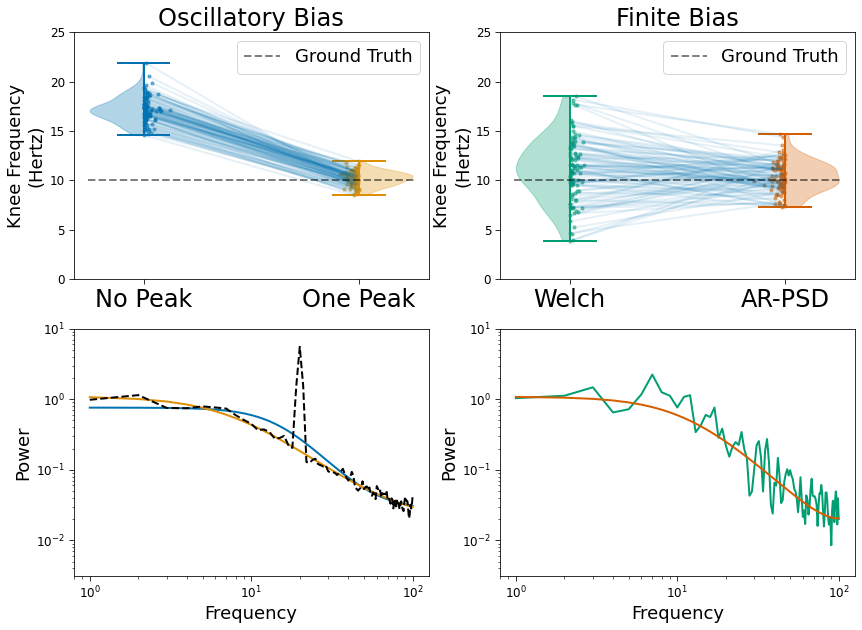

In [11]:
fig = plt.figure(figsize=(14, 10))

gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])


ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Oscillations
xticklabels = ['No Peak', 'One Peak']
plot_connected_scatter(knees_osc_no_peak, knees_osc_peak, ax0, colors=('C0', 'C1'),
                       violin_locs=(1, 2), xticklabels=xticklabels)

# Finite
xticklabels = ['Welch', 'AR-PSD']
plot_connected_scatter(knees_finite_welch, knees_finite_ar, ax1, colors=('C2', 'C3'),
                       violin_locs=(1, 2), xticklabels=xticklabels)

ax0.set_ylabel('Knee Frequency\n(Hertz)')
ax1.set_ylabel('Knee Frequency\n(Hertz)')

ax0.axhline(10, .04, .96, color='k', ls='--', alpha=.5, label='Ground Truth')
ax1.axhline(10, .04, .96, color='k', ls='--', alpha=.5, label='Ground Truth')

ax0.set_ylim(0, 25)
ax1.set_ylim(0, 25)

ax0.set_title('Oscillatory Bias')
ax1.set_title('Finite Bias')

ax0.legend()
ax1.legend()

# Finite Spectra
_f_welch = f_welch[1:]
_p_welch = p_welch[1][1:]

_p_ar = np.interp(_f_welch, f_ar, p_ar[1])

_p_welch = _p_welch / _p_welch[:5].mean()
_p_ar = _p_ar / _p_ar[:5].mean()

ax3.loglog(_f_welch, _p_welch, color='C2')
ax3.loglog(_f_welch, _p_ar, color='C3')
ax3.set_xlabel('Frequency')
ax3.set_ylabel('Power')
ax3.set_ylim(10**-2.5, 1e1)

# Osc Spectra
_f_spikes_osc = f_spikes_osc[1:]
_p_spikes_osc = p_spikes_osc[0][1:]

inds = np.where((_f_spikes_osc >= 1) & (_f_spikes_osc <= 100))

_f_spikes_osc = _f_spikes_osc[inds]
_p_spikes_osc = _p_spikes_osc[inds]
_p_spikes_osc = _p_spikes_osc / _p_spikes_osc[0]
_p_spikes_osc = _p_spikes_osc - (_p_spikes_osc.min()-_p_ar.min())

fooof_init={'max_n_peaks': 0, 'peak_threshold': 2.5}

psd_no_peak = PSD(_f_spikes_osc, _p_spikes_osc)
psd_no_peak.fit(f_range=(1, 100), method='fooof', fooof_init=fooof_init)

fooof_init={'max_n_peaks': 1, 'peak_threshold': 2.5}

psd_peak = PSD(_f_spikes_osc, _p_spikes_osc)
psd_peak.fit(f_range=(1, 100), method='fooof', fooof_init=fooof_init)

ax2.loglog(psd_no_peak.freqs, psd_no_peak.powers_fit)
ax2.loglog(psd_peak.freqs, psd_peak.powers_fit)
ax2.loglog(_f_spikes_osc[inds], _p_spikes_osc[inds], color='k', ls='--')
ax2.set_ylim(10**-2.5, 1e1)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Power')

plt.savefig('fig04_bias_solutions.png', dpi=300, facecolor='white');